# Assignment 08:
# Text Mining and Regression using Dimensionality Reduction Methods [_/100 Marks]

### Follow These Instructions

Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.



#### In this assignment, we will study apply dimensionality reduction methods to improve our understanding of text data and to predict the sentiment of a set of texts. The dataset for this assignment comes from the Amazon website and represents 1,000 reviews which were labeled (by humans) as positive or negative. This application of data science is called [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) and it is widely used across many fields to get automated feedback when text opinions are expressed. You will also work with dimensionality reduction for classification and regression.
---

In [ ]:
import numpy as np
import pandas as pd
import umap
from sklearn.decomposition import PCA, TruncatedSVD
import sklearn.feature_extraction.text as sktext
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt
seed = 221113

---
## Task 1: Decomposition of the texts [ / 50 marks]

### Question 1.1 [ / 9 marks]

The dataset comes with the text and a binary variable which represents the sentiment, either positive or negative. Import the data and use sklearn's `TfidfVectorizer` to eliminate accents, special characters, and stopwords. In addition, make sure to eliminate words that appear in less than 5% of documents and those that appear in over 95%. You can also set `sublinear_tf` to `True`. After that, split the data into train and test with `test_size = 0.2` and `seed = seed`. Calculate the [Tf-Idf transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) for both train and test. Note that you need to fit and transform the inputs for the train set but you only need to transform the inputs for the test set. Don't forget to turn the sparse matrices to dense ones after you apply the `Tf-Idf` transform.  

In [ ]:
# Load the data [ /1 marks]
reviews_data = pd.read_csv('Reviews_sample.csv')

# Display the first 5 rows [ /1 marks]
reviews_data.head()

,text,label
0,Stuning even for the non-gamer: This sound tr...,1
1,The best soundtrack ever to anything.: I'm re...,1
2,Amazing!: This soundtrack is my favorite musi...,1
3,Excellent Soundtrack: I truly like this sound...,1
4,"Remember, Pull Your Jaw Off The Floor After H...",1


In [ ]:
# Defining the TfIDFTransformer [ /2 marks]
TfIDFTransformer = sktext.TfidfVectorizer(strip_accents = 'unicode', # Eliminate accents and special characters
                      stop_words = 'english', # Eliminates stop words
                      min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.95, # Eliminate words that appear in more than 95% of texts
                      sublinear_tf = True # Use sublinear weights (softplus)
                      )


# Train/test split [ /2 marks]
x_train, x_test, y_train, y_test = train_test_split(reviews_data['text'],
                                                    reviews_data['label'],
                                                    test_size = 0.2,
                                                    random_state = seed)

# Calculate the Tf-Idf transform [ /2 marks]
TfIDF_train = TfIDFTransformer.fit_transform(x_train)
TfIDF_test = TfIDFTransformer.transform(x_test)

From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required). Print the number of indices in the ouput using [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [ ]:
# Print the number of indices [ /1 marks]
print('There are %i words in the index.' % len(TfIDFTransformer.get_feature_names_out()))

There are 65 words in the index.


### Question 1.2 [ / 8 marks]
Now we have the TfIDF matrix so we can start working on the data. We hope to explore what some commonly occuring concepts are in the text reviews. We can do this using PCA. A PCA transform of the TF-IDF matrix will give us a basis of the text data, each component representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic. Calculate a PCA transform of the training data using the **maximum** number of concepts possible. Make a plot of the explained variance that shows the cumulative explained variance per number of concepts.

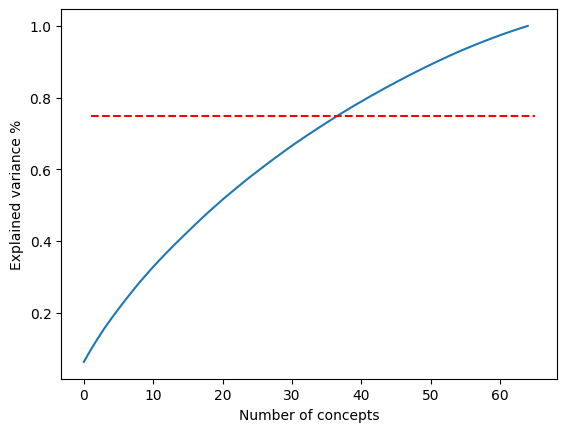

In [ ]:
# Apply PCA on training data and get the explained variance [ / 3 marks]
max_concepts = len(TfIDFTransformer.get_feature_names_out())
PCA_Reviews = PCA(n_components = max_concepts)
PCA_Reviews.fit(np.asarray(TfIDF_train.todense()))
PCA_variances = PCA_Reviews.explained_variance_ratio_


# Plotting explained variance with number of concepts [ / 3 marks]
plt.plot(np.arange(max_concepts), np.cumsum(PCA_variances))
plt.hlines(0.75, xmin = 1, xmax = max_concepts, linestyles = 'dashed', colors = 'red')
plt.xlabel('Number of concepts')
plt.ylabel('Explained variance %')
plt.show()

**Written Question:** Exactly how many concepts do we need to correctly explain at least 80% of the data? [ /2 marks]


In [ ]:
# To get the exact index where the variance is above 80%
index80 = next(x for x, val in enumerate(np.cumsum(PCA_variances)) if val > 0.8)
print(index80)

41


**Your Answer:** We need 41 concepts in order to explain at least 80% of the variance.

### Question 1.3 [ / 12 marks]

Let's examine the first three concepts by looking how many variance they explained and showing the 10 words that are the most important in each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).


In [ ]:
# Explained variance [ / 2 marks]
print('The first three components explain %.2f%% of the variance.' % (np.cumsum(PCA_variances)[2] * 100))

The first three components explain 12.77% of the variance.


In [ ]:
# Get 10 most important words for each component [ / 4 marks]
words_per_row = TfIDFTransformer.get_feature_names_out()
most_important = [np.argpartition(np.abs(PCA_Reviews.components_[i]), -10)[-10:] for i in range(3)]

In [ ]:
# Words for concept 1 [ / 2 marks]
[words_per_row[i] for i in most_important[0]]

['wear',
 'just',
 'bought',
 'written',
 'buy',
 'book',
 'movie',
 'read',
 'reading',
 'product']

In [ ]:
# Words for concept 2 [ / 1 marks]
[words_per_row[i] for i in most_important[1]]

['people',
 'day',
 'buy',
 'better',
 'bought',
 'worst',
 'great',
 'wear',
 'product',
 'movie']

In [ ]:
# Words for concept 3 [ / 1 marks]
[words_per_row[i] for i in most_important[2]]

['know',
 'just',
 'really',
 'book',
 'like',
 'great',
 'love',
 'money',
 'don',
 'movie']


**Written Question:** What is the cumulative variance explained by these three concepts? What would you name each of these concepts? [ / 2 marks]

*Hint: If in a concept you would get the words 'dog', 'cat', 'fish' as the most important ones, you could name the concept 'animals' or 'pets'.*

**Your answer:** There are several interpretations that can be done here, but in general we can say that the first component is mostly about reading, the second one could be positive opinions on movies and the third one hints at recommendation.**

### Question 1.4 [ / 8 marks]

 Apply the PCA transformation to the test dataset. Use only the first two components and make a scatter plot of the cases. Identify positive and negative cases by colouring points with different sentiments with different colours.


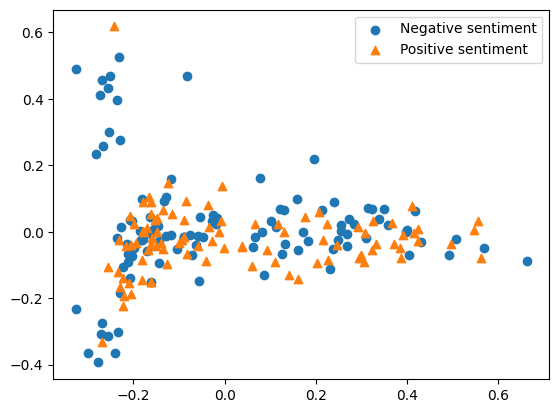

In [ ]:
# Apply PCA to the test dataset [ / 2 marks]
test_pca = PCA_Reviews.transform(np.asarray(TfIDF_test.todense()))


# Plot the two different set of points with different markers and labels [ /4 marks]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(test_pca[:, 0][y_test == 0], test_pca[:, 1][y_test == 0], marker = 'o', label = 'Negative sentiment')
ax.scatter(test_pca[:, 0][y_test == 1], test_pca[:, 1][y_test == 1], marker = '^', label = 'Positive sentiment')
plt.legend()
plt.show(); plt.close()

**Written Question:** What can we say about where the positive and negative cases lie in our plot? Could we use these concepts to discriminate positive and negative cases? If yes, why? If no, why not? Discuss your findings. [ /2 marks]

**Your answer:** The positive cases are way more scattered and they are mostly located above the negative ones. We cannot use the first two components to discriminate positive and negative cases since a large overlap can be seen for both cases where second component is between -0.2 and 0.

### Question  1.5 [ / 13 marks]

Repeat the process above, only now using a UMAP projection with two components. Test all combinations of ```n_neighbors=[2, 10, 25]``` and ```min_dist=[0.1, 0.25, 0.5]``` over the train data and choose the projection that you think is best, and apply it over the test data. Use 1000 epochs, a cosine metric and random initialization. If you have more than 8GB of RAM (as in Colab), you may want to set ```low_memory=False``` to speed up computations.

*Hint: [This link](https://stackoverflow.com/questions/16384109/iterate-over-all-combinations-of-values-in-multiple-lists-in-python) may be helpful.*



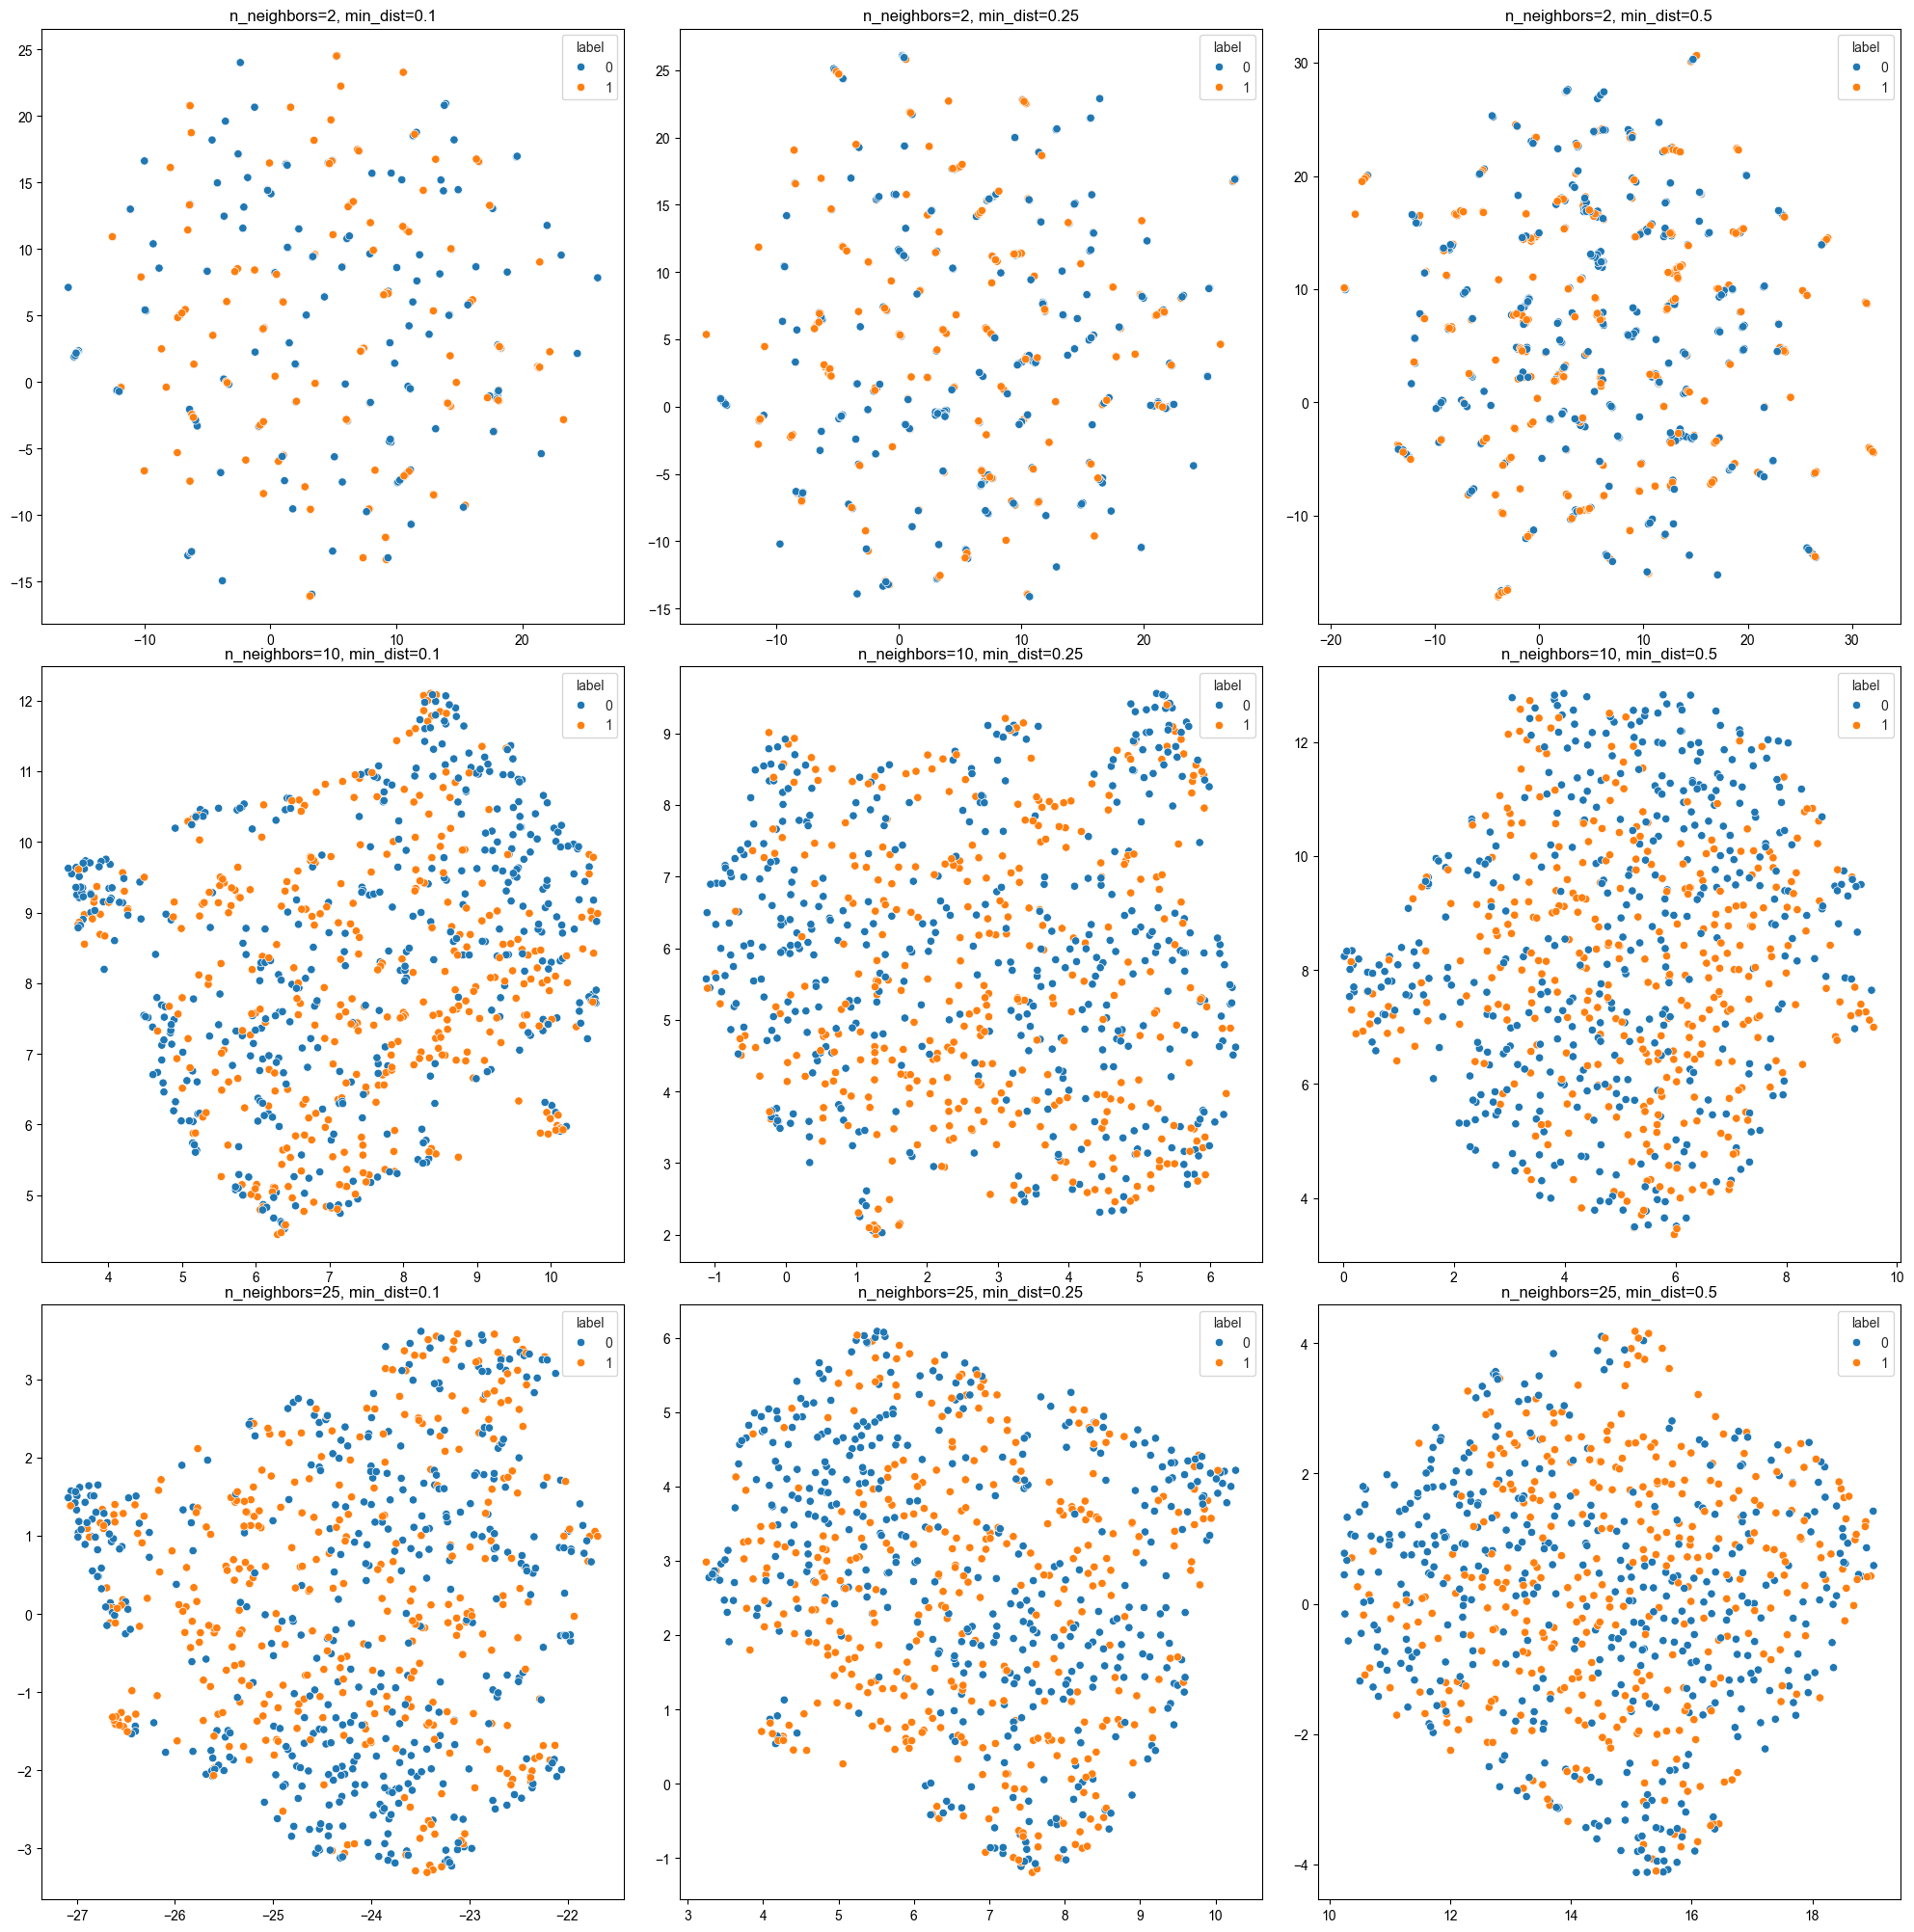

In [ ]:
# Set parameters [ / 4 marks]
fig, axs = plt.subplots(3, 3, figsize=(20,20))
n_neighbors=[2, 10, 25]
min_dist=[0.1, 0.25, 0.5]
fig.tight_layout()
sns.set_style('white')
for (i,j), (nei, dist) in zip(product([0,1,2],[0,1,2]), product(n_neighbors, min_dist)):
    UMAP_Reviews = umap.UMAP(n_components = 2,
                             metric='cosine',
                             n_epochs=1000,
                             low_memory=False,
                             n_neighbors=nei,
                             min_dist=dist,
                             init='random'
                            )

    x_train_umap = UMAP_Reviews.fit_transform(TfIDF_train)

    # Create plot [ [ /2 marks]]
    sns.scatterplot(x=x_train_umap[:, 0], y=x_train_umap[:, 1], hue=y_train, ax=axs[i,j])
    axs[i,j].title.set_text(f"n_neighbors={nei}, min_dist={dist}")

plt.show()

**Written Question:** Which paramter would you choose? [ / 2 makrs]

**Your Answer:** We can see that 2 neighbours is too little and there are limited gains from using 25 neighbours. Regarding min_dist, 0.1 has the best structure (for me at least, they can argue differently and it should be considered correct).

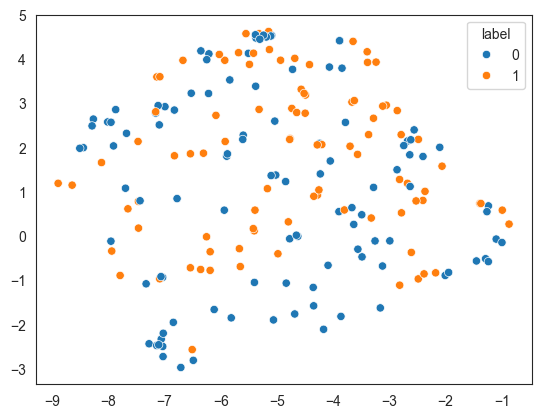

In [ ]:
# Choose the paramters that you think are best and apply to test set [ / 2 marks]
UMAP_Reviews = umap.UMAP(n_components = 2,
                          metric='cosine',
                          n_epochs=5000,
                          low_memory=False,
                          n_neighbors=10,
                          min_dist=0.1,
                          init='random'
                        )

x_train_umap = UMAP_Reviews.fit_transform(TfIDF_train)
x_test_umap = UMAP_Reviews.transform(TfIDF_test)

# Create plot [ /1 marks]
sns.scatterplot(x=x_test_umap[:, 0], y=x_test_umap[:, 1], hue=y_test)
plt.show(); plt.close()


**Written Question:** How does the plot compare to the PCA one? [ /2 marks]

**Your answer:** The new plot looks fairly different than the PCA one. We see other structures and some non-linear separation between the cases. Still, there is no easy way of separating the different reviews.

---
## Task 2: Benchmarking predictive capabilities of the compressed data [ /24 marks]

For this task, we will benchmark the predictive capabilities of the compressed data against the original one.



### Question 2.1 [ /6 marks]
Train a regularized logistic regression over the original TfIDF train set (with no compression) using l2 regularization. Calculate the AUC score and plot the ROC curve for the original test set. Use the training/test split created in Q1.1.

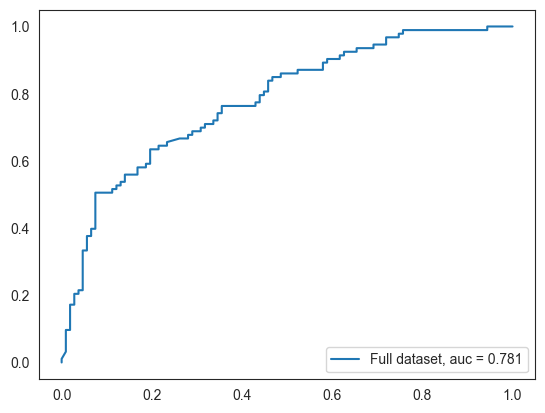

In [ ]:
# Train and test using model LogisticRegressionCV [ /4 marks]

# Define the model
LogRegFull = LogisticRegressionCV(Cs = 10,
                                  cv = 3,
                                  penalty = 'l2',
                                  solver = 'lbfgs',
                                  tol = 0.0001,
                                  max_iter = 1000,
                                  n_jobs = -1,
                                  refit = True,
                                  random_state = seed
                                 )

# Fit on the training dataset
from sklearn.preprocessing import StandardScaler
# we are working with sparse X, therefore standardization wouldn't help,
# but still let's do it to see how to code it for a sparse X
scaler_X = StandardScaler(with_mean=False)
scaler_X.fit(TfIDF_train)
LogRegFull.fit(scaler_X.transform(TfIDF_train), y_train)

# Apply to the test dataset
probs_test_full = LogRegFull.predict_proba(scaler_X.transform(TfIDF_test))

# Plot ROC curve and compute AUC score [ /2 marks]
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, probs_test_full[:, 1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = y_test,
                             y_score = probs_test_full[:, 1]), decimals = 3)

# Create and show the plot
plt.plot(fpr, tpr, label = "Full dataset, auc = " + str(auc))
plt.legend(loc = 4)
plt.show(); plt.close()

### Question 2.2 [ /8 marks]
Train a regularized logistic regression over an SVD-reduced dataset (with 10 components) using l2 regularization. Calculate the AUC score and plot the ROC curve for the SVD-transformed test set.

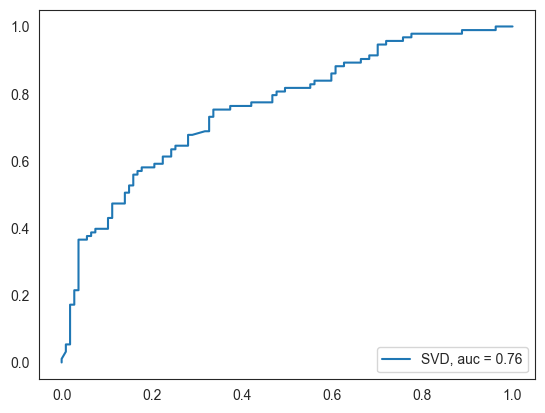

In [ ]:
# Apply SVD first [ / 3 marks]
SVD_Reviews = TruncatedSVD(n_components = 10,
                           n_iter=10,
                           random_state=42
                           )
x_train_pca = SVD_Reviews.fit_transform(TfIDF_train)
x_test_pca = SVD_Reviews.transform(TfIDF_test)

#Train and test using model LogisticRegressionCV [ /3 marks]
LogRegSVD = LogisticRegressionCV(Cs = 10,
                                 cv = 3,
                                 penalty = 'l2',
                                 solver = 'lbfgs',
                                 tol = 0.0001,
                                 max_iter = 1000,
                                 n_jobs = -1,
                                 refit = True,
                                 random_state = 123456789
                                 )

scaler_X = StandardScaler(with_mean=False)
scaler_X.fit(x_train_pca)
LogRegSVD.fit(scaler_X.transform(x_train_pca), y_train)
probs_test_svd = LogRegSVD.predict_proba(scaler_X.transform(x_test_pca))

# Plot ROC curve and compute AUC score [ /2 marks]
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, probs_test_svd[:, 1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = y_test,
                             y_score = probs_test_svd[:, 1]), decimals = 3)

# Create and show the plot
plt.plot(fpr, tpr, label = "SVD, auc = " + str(auc))
plt.legend(loc = 4)
plt.show(); plt.close()

### Question 2.3 [ /8 marks]
Train an l2-regularized logistic regression over a UMAP-reduced version of the dataset. For this reduction use a UMAP with 10 components and make a judge call from the figures created in Task 1.5 to pick a value for `n_neighbors` and `min_dist`, and take the rest of the parameters the same as Task 1.5. Calculate the AUC score and plot the ROC curve for the UMAP-transformed test set.

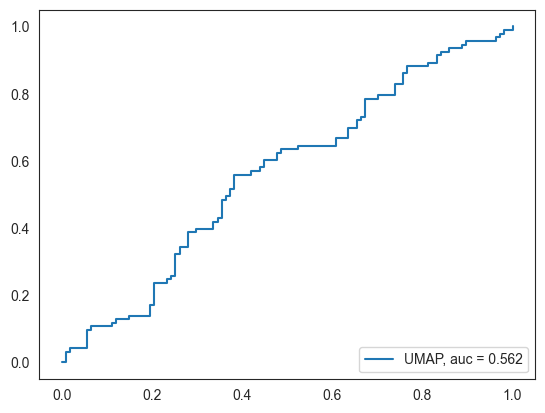

In [ ]:
# Apply UMAP first [ / 3 marks]
UMAP_Reviews = umap.UMAP(n_components = 2,
                          metric='cosine',
                          n_epochs=5000,
                          low_memory=False,
                          n_neighbors=10,
                          min_dist=0.1,
                          init='random'
                        )

x_train_umap = UMAP_Reviews.fit_transform(TfIDF_train)
x_test_umap = UMAP_Reviews.transform(TfIDF_test)

#Train and test using model LogisticRegressionCV [ /3 marks]
LogRegUMAP = LogisticRegressionCV(Cs = 10,
                                  cv = 3,
                                  penalty = 'l2',
                                  solver = 'lbfgs',
                                  tol = 0.0001,
                                  max_iter = 1000,
                                  n_jobs = -1,
                                  refit = True,
                                  random_state = 123456789
                                  )

scaler_X = StandardScaler(with_mean=False)
scaler_X.fit(x_train_umap)
LogRegUMAP.fit(scaler_X.transform(x_train_umap), y_train)
probs_test_umap = LogRegUMAP.predict_proba(scaler_X.transform(x_test_umap))


# Plot ROC curve and compute AUC score [ /2 marks]
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, probs_test_umap[:, 1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = y_test,
                             y_score = probs_test_umap[:, 1]), decimals = 3)

# Create and show the plot
plt.plot(fpr, tpr, label = "UMAP, auc = " + str(auc))
plt.legend(loc = 4)
plt.show(); plt.close()

### Question 2.4 [ /2 marks]
**Written Question:** Compare the performance of the three models. Which one is the best. [ / 2 marks]

**Your Answer:** It can be seen that the model trained over the original data performs better than those trained over the reduced data. However, SVD and exhibits acceptable predictive capabilities. As UMAP did a non-linear mapping, its result is not good for logistic regression, that looks for linear separations, so the performance is not good at all. This can probably be improved using a non-linear model such as XGB.

---
## Task 3: PCA + Hockey [ / 26 marks]
Connor Andrew McDavid is a Canadian professional ice hockey player and captain of the Edmonton Oilers of the National Hockey League (NHL). The data file `Hockey_sample.csv` provides a reduced version of Connor's game by game career data. Each row represents the stats of one game. The dataset has the following attributes:

|#| Attribute | Description |
| --- | --- | --- |
|0|`opposingTeam`|The team the player played against.|
|1|`home_or_away`|Whether a game was played home or away.|
|2|`icetime`|Log10 of total time the player played in seconds.|
|3|`gameScore`|Game score rating.|
|4|`I_F_primaryAssists`|Primary Assists the player has received on teammates' goals.|
|5|`I_F_secondaryAssists`|Secondary Assists the player has received on teammates' goals.|
|6|`log10_I_F_shotAttempts`|Log10 of shot attempts. Includes player's shots on goal, missed shots, and blocked shot attempts.|
|7|`I_F_goals`|Number of goals the player scored.|
|8|`I_F_rebounds`|Rebound shot attempts. These must occur within 3 seconds of a previous shot.|
|9|`I_F_reboundGoals`|Goals from rebound shot attempts.|
|10|`I_F_freeze`|Puck freezes after a player's shot. The  number of puck freezes by goalies after the player's unblocked shot attempts.|
|11|`I_F_playContinuedInZone`|Number of times the play continues in the offensive zone after the player's shot besides an immediate rebound shot.|
|12|`I_F_playContinuedOutsideZone`|Number of times the play goes outside the offensive zone after the player's shot.|
|13|`I_F_savedShotsOnGoal`|Number of the player's unblocked shots that were saved by the goalie.|
|14|`I_F_savedUnblockedShotAttempts`|Number of the player's unblocked shots that were saved by the goalie or missed the net.|
|15|`I_F_penalityMinutes`|Number of penalty minutes the player has received.|
|16|`log10_I_F_faceOffsWon`|Log10 of number of faceoffs the player has won.|
|17|`I_F_hits`|Number of hits the player has given.|
|18|`I_F_takeaways`|Number of takeaways the player has taken from opponents.|
|19|`I_F_giveaways`|Number of giveaways the player has given to other team.|
|20|`I_F_lowDangerGoals`|Goals from low danger shots.|
|21|`I_F_mediumDangerGoals`|Goals from medium danger shots.|
|22|`I_F_highDangerGoals`|Goals from high danger shots.|
|23|`I_F_unblockedShotAttempts`|All shot attempts that weren't blocked.|
|24|`I_F_dZoneGiveaways`|Giveaways in the team's defensive zone.|
|25|`penalityMinutesDrawn`|Number of penalty minutes the player has drawn.|
|26|`penaltiesDrawn`|Number of penalties the player has drawn.|

### Question 3.1 [ / 6 marks]

Drop categorical attributes, standardize numerical ones, and finally, with "icetime" as your target create the matrix of predictors and target vector, calling them `X1` and `y`, respectively. What is the `shape` of `X1` and `y`?

Hint they should be as the following:

Shape of X1: (2725, 24)

Shape of y: (2725,)

In [ ]:
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('./Hockey_sample.csv')

X = df.drop(['icetime'], axis=1).copy()

numList = X.select_dtypes("number").columns
objList = X.select_dtypes("object").columns

scaler = StandardScaler()
for feature in numList:
    X[[feature]] = scaler.fit_transform(X[[feature]])

X1 = X.drop(objList, axis=1)
y = df['icetime'].copy()

print('Shape of X1:', X1.shape)
print('Shape of y:', y.shape)

Shape of X1: (2725, 24)
Shape of y: (2725,)


### Question 3.2 [ / 10 marks]

Use a 15-component regular PCA to transform `X1` and create the scree plot. Let $p$ be the **minimum** number of PCs required in order to capture at least 80% of total variance. What would be the value of $p$? Reduce the dimension of `X1` to $p$ and call this new array `X2` (retain `X1` intact though, we need it for later).

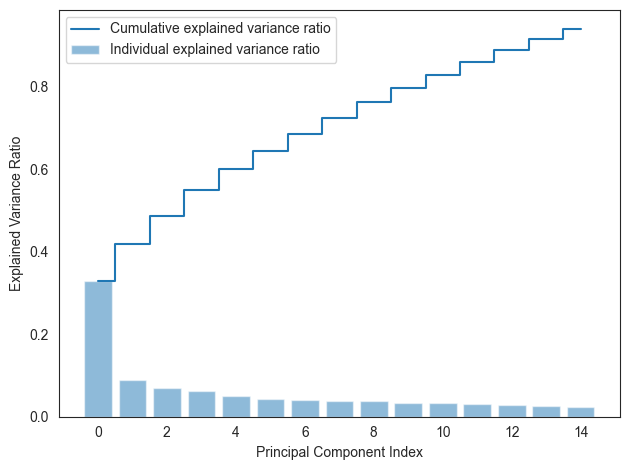


The minimum number of PCs to consider in order to capture
at least 80% of total variance is 10.


In [ ]:
n = 15
transformer1 = PCA(n)
transformer1.fit(X1)
X1_transformed = transformer1.transform(X1)

exp_var = transformer1.explained_variance_ratio_
cum_sum = np.cumsum(exp_var)

plt.bar(range(0,len(exp_var)), exp_var, alpha=0.5, align='center', label='Individual explained variance ratio')
plt.step(range(0,len(cum_sum)), cum_sum, where='mid', label='Cumulative explained variance ratio')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

numPC = next(x for x, val in enumerate(np.cumsum(exp_var)) if val > 0.8)
print(f'\nThe minimum number of PCs to consider in order to capture\nat least 80% of total variance is {numPC}.')

X2 = X1_transformed[:,:numPC]

### Question 3.3 [ / 10 marks]

Now that you have 2 different design matrices (*i.e.*, `X1` and `X2`) let's try two different scenarios: Train a simple linear regression (with default arguments) once using `X1`, and another time using the combination of `X1` and `X2` (*i.e.* concatenate them). Use cross-validation with RMSE as the error measure to identify the best model among the two. Report the cross-validation RMSE along with thier CIs for both models. Also report the loss of the best model on the test set.

(For the cross-validation, do five-fold shuffled. For train/test split, use sklearn's default value for test set size.)

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression

def evaluate(model, Xtrain, Xtest, ytrain, ytest, text):
    model.fit(Xtrain, ytrain)
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    cv_scores = cross_val_score(model, Xtrain, ytrain, cv=kf, scoring='neg_root_mean_squared_error')
    print('\n'+text)
    print('Average CV RMSE: %.4f +/- %.4f' % (-cv_scores.mean(), cv_scores.std()))


LR = LinearRegression(n_jobs=-1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y.values, random_state=seed)
evaluate(LR, Xtrain, Xtest, ytrain, ytest, 'Model 1')

Xtrain, Xtest, ytrain, ytest = train_test_split(np.concatenate((X1, X2), axis=1), y.values, random_state=seed)
evaluate(LR, Xtrain, Xtest, ytrain, ytest, 'Model 2')

# Very similar models, however, Model 1 wins.

from sklearn.metrics import mean_squared_error
Xtrain, Xtest, ytrain, ytest = train_test_split(X1, y.values, random_state=seed)
print("Test RMSE:", np.sqrt(mean_squared_error(ytest, LR.fit(Xtrain, ytrain).predict(Xtest))).round(4))


Model 1
Average CV RMSE: 0.5685 +/- 0.0188

Model 2
Average CV RMSE: 0.5709 +/- 0.0181
Test RMSE: 0.5841


---
$$The End$$